<a href="https://colab.research.google.com/github/MichalSlowakiewicz/DNN-Homeworks/blob/master/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2: Image segmentation without user input**

## Overview
This homework has two parts.

The first part of this homework is to implement [Grad-CAM](https://arxiv.org/pdf/1610.02391) – a method for producing saliency maps (heatmaps of regions that are most relevant to a model) that uses both activations and gradients of the feature maps of a convolutional layer. Feature maps of deeper convolutional layers represent more high-level features, while preserving rough spatial structure, which makes them a good candidate for explaining a model's output.

The second part of this homework is to use SAM for image segmentation without user input.
SAM [(Segment Anything Model v1)](https://arxiv.org/pdf/2304.02643) is a popular family of open-weight models for image segmentation (based on the vision transformer ViT and CLIP).
The model takes as input an image to be segmented and additionaly bounding boxes, point coordinates etc. clarifying the object of interest to be segmented. It can output many proposed segmentations of many objects on one image. Your task will be to find appropriate point coordinates automatically, so that SAM can be used with just an image input to segment particular objects.

---

## Dataset

You will use a small custom dataset based on [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10), but containing images with one of five objects (circle, square, diamond, triangle, star), with ground-truth segmentations of that object.

---

## GradCAM task

For the first task:
* Read the original [Grad-CAM](https://arxiv.org/pdf/1610.02391) paper.
* Implement it, without using non-standard packages (the only imports allowed are built-ins, torch, torchvision, numpy, scipy, and helpers like cv2, PIL, tqdm, matplotlib).
* The result should be a class named `GradCAM` with methods:
    * `def __init__(model: nn.Module, target_layers=Iterable[nn.Module])`
    * `def __call__(self, image: Tensor, targets: Iterable[int] | None = None) -> np.ndarray` where
        * `image` is an input to `model` (a normalized batch of shape `B,C,H,W`).
        * `targets` is an iterable of target classes that we want to segment; if None is given, use the top class predicted by the model.
        * The result is a numpy array of shape (B, H, W) containing the GradCam heatmap, with `min..max` values rescaled to `0..1` (independently for each image in the batch and each `target_layers`). If more than one `target_layers` was given, return the average of the resulting heatmaps.      
    * Feel free to add optional/default arguments and additional methods.
* Check your implementation by running the code under the `GradCAM results` header.

Tip: you may find it particularly useful to use: [nn.Module.register_full_backward_hook](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook).


## Segmentation task

For the second part, SAM is given as a black-box. You must design a pipeline that takes only an image and outputs a segmentation of the circle/square/diamond/triangle/star shape. The input to SAM should be the image and coordinates of point(s) that are likely to be inside ("foreground") or likely to be outside ("background") of the shape. **The coordinates must be the output of the previous step of the pipeline. They cannot be provided directly by user.**

* Think of a way to find appropriate points. Try two different approaches:
    1. at least one foreground point, without background points.
    2. at least one foreground point and at least one background point.
* Implement both approches as subclasses of `BasicSamPipeline`, overriding the `__call__` method (preserving the signature).
* Evaluate your generated point(s) and report the following metrics:
    * *hit rate*: how often they fall inside the ground-truth mask;
    * *distance*: distance from the center of mass of the ground-truth mask
        (the average coordinate of True pixels in the mask).
* Evaluate your overall pipeline and report the following metric:
    * *Intersection over Union (IoU)* of the predicted and ground-truth masks, averaged over all images in the dataset.


**Important**: This task is not about finding the pipeline with best hyperparameters; we expect an IoU of at least `65%`, but achieving results higher than that will not affect the grade for the assignment.

**Important**: Do not train or fine-tune your own models, only use the ones provided (the classifier and SAM).

---

## Deliverables

On [Moodle](https://moodle.mimuw.edu.pl/mod/assign/view.php?id=159965), submit a .zip archive with:

1. **Notebook** (`.ipynb`):
    * It should contain:
        * The GradCAM implementation.
        * The two `BasicSamPipeline` subclasses.
        * Evaluations with computations of all reported metrics.
    * It should be possible to execute the whole notebook start-to-end without human intervention.
    * Such an execution should take less than 30 minutes on a Colab GPU.
    * Do not modify (but *do* execute) cells under headers marked as `[do not modify]`. If you wish to extend them (e.g. to check more GradCAM results), you may do so **under a new header**.

2. **Report (1-2 pages, PDF)** including:
   * An examplary visualization of the output of the Grad-CAM
   * A concise description of each approach for the SAM pipelines (1-3 sentences each).
   * A presentation of all metrics.
   * Discussion (up to 5 sentences) on potential areas for improvements.

3. **README.md**:
   * Link to Colab version of the notebook for fast replication.



## Grading

1. Implementation correctness of Grad-CAM:  30%
2. Implementation correctness of the multistage pipeline and evaluations: 50%
3. Report & analysis: 20%

Please take care of readability, clear structure in particular (headers in notebooks, modular code).
This will be considered within each grading component.



# **Project: Image segmentation without user input**
---
### **Introduction**
This project focused on constructing an automated **image segmentation pipeline** consisting of two main parts:



1.   **Grad-CAM Implementation**: a method for producing saliency maps (heatmaps of regions that are most relevant to a model) to interpret the classifier's focus.
2.   **SAM Pipelines**: an automated workflow using heatmaps generated by Grad-CAM to obtain  foreground and background points for the SAM model. This enables fully automated segmentation of geometric shapes.


Runtime: around 17 minutes on Colab T4 GPU.

---
**Author:** Michał Słowakiewicz, 448827

# 0. Preliminaries

---
This section is responsible for downloading and preparation of the dataset, importing the necessary libraries and seeting random seed for reproductability of the code. Also classifier is trained in this section.

## Imports

In [1]:
# !pip install torch torchvision matplotlib opencv-python-headless numpy segment-anything

In [2]:
import os
import random
from collections.abc import Callable, Iterable
from pathlib import Path
from typing import Any, Final, Literal, TypedDict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.ndimage
import torch
import torch.nn.functional as F
import torchvision.models
from torch import Tensor, nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from tqdm import tqdm

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

## Dataset [do not modify]

CIFAR-10 download takes 170 MiB.

In [4]:
%%bash --no-raise-error
mkdir -p data/
wget -nc -q -O data/synthetic_shapes.zip https://www.mimuw.edu.pl/~mwrochna/upload/synthetic_shapes.zip
unzip -d data/ data/synthetic_shapes.zip &> /dev/null

In [5]:
class SyntheticData[T](Dataset):
    """A small synthetic segmentation dataset.

    It is a sequence dataset of 5000 tuples (image, class, mask), where:
    - image: before transformation, an RGB PIL Image.
    - class: int 0..4, the label index.
    - mask:  numpy array of dtype=bool, shape (H, W), same size as image.
    """

    CLASSES: Final[tuple[str, ...]] = ("circle", "square", "triangle", "star", "diamond")

    def __init__(
        self,
        path: Path,
        split: Literal["train", "val", "test"],
        transform: Callable[[PIL.Image.Image], T],
    ) -> None:
        self.path = path
        self.transform = transform
        self.split = split

        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.CLASSES)}

        images = sorted((self.path / "images" / self.split).glob("*.png"))
        masks = sorted((self.path / "masks" / self.split).glob("*.png"))
        labels = sorted((self.path / "labels" / self.split).glob("*.txt"))

        assert images, f"No images found in {self.path / 'images' / self.split}"
        assert len(images) == len(masks) == len(labels), (
            "Number of images, masks, and labels must be the same"
        )
        assert [p.stem for p in images] == [p.stem for p in masks] == [p.stem for p in labels], (
            "Image/mask/label filename mismatch."
        )
        self.image_names = [p.stem for p in images]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx) -> tuple[T, int, np.ndarray]:
        name = self.image_names[idx]
        img_path = self.path / "images" / self.split / f"{name}.png"
        mask_path = self.path / "masks" / self.split / f"{name}.png"
        label_path = self.path / "labels" / self.split / f"{name}.txt"

        img = PIL.Image.open(img_path).convert("RGB")
        mask = np.array(PIL.Image.open(mask_path), dtype=bool)
        label = self.class_to_idx[label_path.read_text().strip()]

        img_transformed: T = self.transform(img)

        return img_transformed, label, mask


def show_image_row(
    image_dict: dict[str, PIL.Image.Image | np.ndarray | Tensor], size: float = 3.0
) -> None:
    n = len(image_dict)
    _, axs = plt.subplots(1, n, figsize=(size * n, size), constrained_layout=True, squeeze=True)
    if n == 1:
        axs = [axs]
    for ax, (title, img) in zip(axs, image_dict.items(), strict=True):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.show()

train dataset size: 3500
val dataset size: 1000
test dataset size: 500


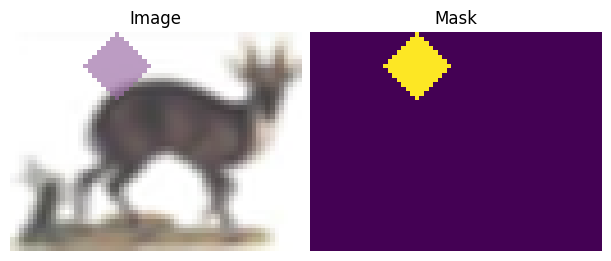

Label: 4 (diamond)


In [6]:
dataset_path = Path("./data/synthetic_shapes")


def example_from_dataset(idx: int = 3):
    for split in ("train", "val", "test"):
        dataset = SyntheticData(dataset_path, split=split, transform=lambda x: x)
        print(f"{split} dataset size: {len(dataset)}")

    img, label, mask = dataset[idx]
    show_image_row({"Image": img, "Mask": mask})
    print(f"Label: {label} ({SyntheticData.CLASSES[label]})")


example_from_dataset()

## Training a classifier [do not modify]

In [7]:
def train(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int = 5,
    **optimizer_kwargs: Any,
) -> None:
    print(f"🚀 Training CNN for {epochs} epochs...")
    optimizer = optim.AdamW(model.parameters(), **optimizer_kwargs)

    for epoch in range(epochs):
        _train_epoch(model, train_loader, optimizer, desc=f"Epoch {epoch + 1}/{epochs} training  ")
        val_metrics = evaluate(model, val_loader, desc=f"Epoch {epoch + 1}/{epochs} validation")
        print(
            f"Epoch {epoch + 1}/{epochs} — "
            + f"val loss: {val_metrics['loss']:.3f}, val acc: {val_metrics['accuracy']:.1%}"
        )

    test_metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print(
        "✅ Model training complete: "
        + f"Test loss: {test_metrics['loss']:.3f}, test acc: {test_metrics['accuracy']:.1%}"
    )


def _train_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: optim.Optimizer,
    desc: str,
) -> dict[str, float]:
    model.train()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    progress_bar = tqdm(dataloader, desc=desc)
    for imgs, labels, _ in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.shape[0]
        total_correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(
            train_loss=f"{total_loss / (total_samples / labels.shape[0]):.3f}",
            train_acc=f"{total_correct / total_samples:.1%}",
        )

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


def evaluate(
    model: nn.Module, dataloader: torch.utils.data.DataLoader, desc: str
) -> dict[str, float]:
    model.eval()
    device = next(model.parameters()).device
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for imgs, labels, _mask in tqdm(dataloader, desc=desc):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, dim=1)
            total_samples += labels.shape[0]
            total_correct += (predicted == labels).sum().item()

    return {"loss": total_loss / len(dataloader), "accuracy": total_correct / total_samples}


class DataloaderArgs(TypedDict, total=False):
    batch_size: int
    shuffle: bool
    num_workers: int
    pin_memory: bool

In [8]:
device = torch.accelerator.current_accelerator(check_available=True) or torch.device("cpu")
use_accel = device != torch.device("cpu")
print(use_accel, device)

True cuda


In [9]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
inverse_transform = v2.Compose(
    [
        v2.Normalize(
            [-m / s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD, strict=True)],
            [1 / s for s in IMAGENET_STD],
        ),
        v2.ToPILImage(),
    ]
)

train_dataset = SyntheticData(dataset_path, transform=transform, split="train")
val_dataset = SyntheticData(dataset_path, transform=transform, split="val")
test_dataset = SyntheticData(dataset_path, transform=transform, split="test")

train_kwargs: DataloaderArgs = {
    "batch_size": 128,
    "num_workers": 2,
    "shuffle": True,
    "pin_memory": use_accel,
}
val_kwargs: DataloaderArgs = {"batch_size": 500, "num_workers": 2, "pin_memory": use_accel}
test_kwargs: DataloaderArgs = val_kwargs

train_loader = DataLoader(train_dataset, **train_kwargs)
val_loader = DataLoader(val_dataset, **val_kwargs)
test_loader = DataLoader(test_dataset, **test_kwargs)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print("✅ DataLoaders created for train, validation, and test sets.")

Train dataset size: 3500
Validation dataset size: 1000
Test dataset size: 500
✅ DataLoaders created for train, validation, and test sets.


In [10]:
checkpoint_path = Path("./model_checkpoint.pth")

model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(SyntheticData.CLASSES))
model = model.to(device)

if not checkpoint_path.exists():
    train(model, train_loader, val_loader, test_loader, epochs=5, lr=2e-3, weight_decay=0.05)
    torch.save(model.state_dict(), checkpoint_path)
else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    metrics = evaluate(model, test_loader, desc="Test Evaluation")
    print()
    print(
        "✅ Model loaded from checkpoint: "
        + f"Test loss: {metrics['loss']:.3f}, test acc: {metrics['accuracy']:.1%}"
    )

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


🚀 Training CNN for 5 epochs...


Epoch 1/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


Epoch 1/5 — val loss: 1.351, val acc: 51.7%


Epoch 2/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


Epoch 2/5 — val loss: 0.371, val acc: 85.4%


Epoch 3/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


Epoch 3/5 — val loss: 0.294, val acc: 89.8%


Epoch 4/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


Epoch 4/5 — val loss: 0.546, val acc: 83.7%


Epoch 5/5 validation: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch 5/5 — val loss: 0.533, val acc: 86.4%


Test Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

✅ Model training complete: Test loss: 0.407, test acc: 89.6%


# 1. GradCAM
---
In this section, the Grad-CAM class was implemented. This method allows us to visualize which regions of the input image are most significant for the model's prediction.

Our Grad-CAM class works by registering hooks with *register_full_backward_hook* and *register_forward_hook* methods, as was mentioned in the hint.

## GradCAM implementation (add your code)

In [11]:
class GradCAM:
    """
    Pure PyTorch implementation of Grad-CAM.

    Usage:
        grad_cam = GradCAM(model=model, target_layers=[layer1, layer2])
        grayscale_cam = grad_cam(input_tensor, targets=[class_id])
    """

    def __init__(self, model: nn.Module, target_layers: Iterable[nn.Module]) -> None:
        self.model = model
        self.model.eval() # setting evaluation mode
        self.target_layers = target_layers

        # defining dictionaries for storing activation and gradients
        self.activations = {}
        self.gradients = {}

        # saving activations and gradients
        for layer in self.target_layers:
          # using 'register_full_backward_hook method from the hint to save gradients for each layer
          layer.register_full_backward_hook(self.save_gradient)

          # using analogical 'register_forward_hook' method to save activations
          layer.register_forward_hook(self.save_activation)

    def __call__(self, input_tensor: Tensor, targets: Iterable[int] | None = None) -> np.ndarray:
        """
        Returns: numpy array of shape (B, H, W), values 0..1.
        """
        # obtaining outputs by passing input tensor through model
        outputs = self.model(input_tensor)

        # when targets are not delivered, we set target as most likely class according to the model
        if targets is None:
          targets = outputs.argmax(dim=1)

        # converting targets to tensor
        if not isinstance(targets, torch.Tensor):
          targets = torch.tensor(targets, device=input_tensor.device)

        # setting gradients to zero
        self.model.zero_grad()

        # choosing results for certain class within the batch
        target_scores = outputs[torch.arange(input_tensor.shape[0]), targets]

        # we sum 'target_scores', so that we can compute backward for the whole batch instead of computing it for each image
        # 'retain_graph=True' was set in order to avoid deleting the graph used for computing gradients (?)
        target_scores.sum().backward(retain_graph=True)

        # creating list used for heatmaps
        heatmaps = []

        # loop iterating though layers
        for layer in self.target_layers:
          activs = self.activations[layer]
          grads = self.gradients[layer]

          # Following computations are using formulas from GradCAM paper
          # computing weights by taking mean over height and width dimensions
          weights = torch.mean(grads, dim=(2, 3), keepdim=True)

          # multipling features by their weigths
          weighted_activations = weights * activs

          # summing 'weighted_activations' along channels
          Y = torch.sum(weighted_activations, dim=1)

          # applying ReLU
          Y = F.relu(Y)

          # adding to heatmaps list
          heatmaps.append(Y)

        # Now after we computed values for heatmaps list, we will move to normalizing and scaling the output
        # as a result we will build 'np.array(result)' of desired size and vaulues

        if len(heatmaps) > 1:
          # we calculate mean for heatmaps
          cam = torch.stack(heatmaps, dim=0).mean(dim=0)
        else:
          cam = heatmaps[0]

        # list for results
        results = []

        # obtaining height and width of 'input_tensor'
        h, w = input_tensor.shape[2], input_tensor.shape[3]

        # moving 'cam' to cpu
        cam = cam.detach().cpu().numpy()

        # loop through all objects in batch
        for i in range(cam.shape[0]):
          heatmap = cam[i]

          # changing size on heatmap to one corresponding with 'input_tensor'
          heatmap = cv2.resize(heatmap, (w, h))

          # normalization to values in the interval (0, 1)
          # we use min-max normalization
          min_hp = heatmap.min()
          max_hp = heatmap.max()
          eps = 1e-12
          heatmap = (heatmap - min_hp) / (max_hp - min_hp + eps)

          # updating results
          results.append(heatmap)

        # converting to numpy array
        results = np.array(results)

        return results


    # helper function for forward hook
    def save_activation(self, module, input, output):
        self.activations[module] = output.detach()

    # helper function for backward hook
    def save_gradient(self, module, grad_input, grad_output):
      self.gradients[module] = grad_output[0].detach()

## GradCAM results [do not modify]

In [12]:
if type(model).__name__ == "ResNet":
    target_layers = [model.layer2[-1]]
else:
    target_layers = [
        model.get_submodule("features.2.0"),
        model.get_submodule("features.3.0"),
        model.get_submodule("features.4.0"),
    ]
print(f"Using layers for Grad-CAM: {[type(layer).__name__ for layer in target_layers]}")

Using layers for Grad-CAM: ['BasicBlock']


In [13]:
def heatmap_to_rgb_image(
    heatmap: np.ndarray, min: float | None = None, max: float | None = None
) -> PIL.Image.Image:
    """
    Converts a single-channel heatmap to an RGB pillow image using a colormap.

    Args:
    - heatmap: shape (H, W), will be normalized by mapping min..max to 0..1.
    - min: minimum value for normalization, defaults to heatmap.min().
    - max: maximum value for normalization, defaults to heatmap.max()
    """
    heatmap = heatmap.astype(np.float32)
    if min is None:
        min = heatmap.min()
    if max is None:
        max = heatmap.max()
    heatmap = (heatmap - min) / (max - min + 1e-8)
    heatmap_uint8 = (np.clip(heatmap, 0.0, 1.0) * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    return PIL.Image.fromarray(heatmap_color)

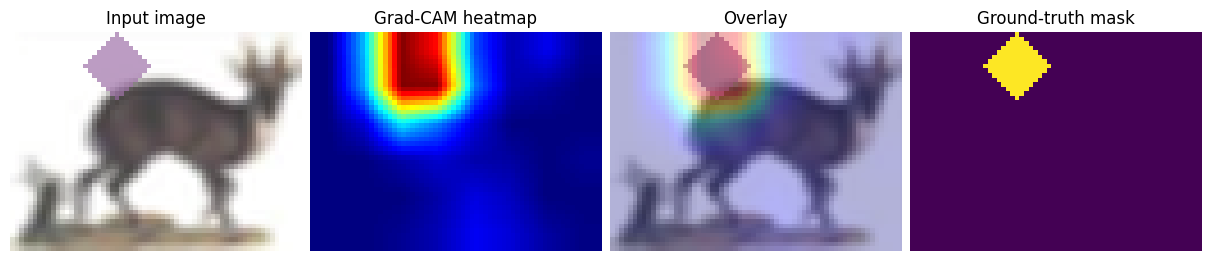

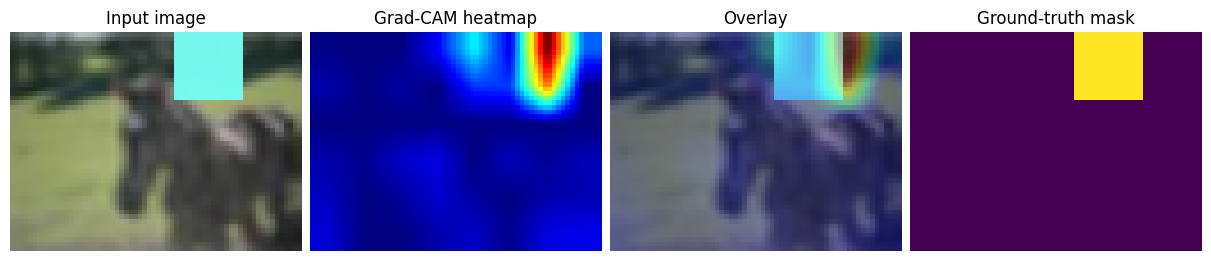

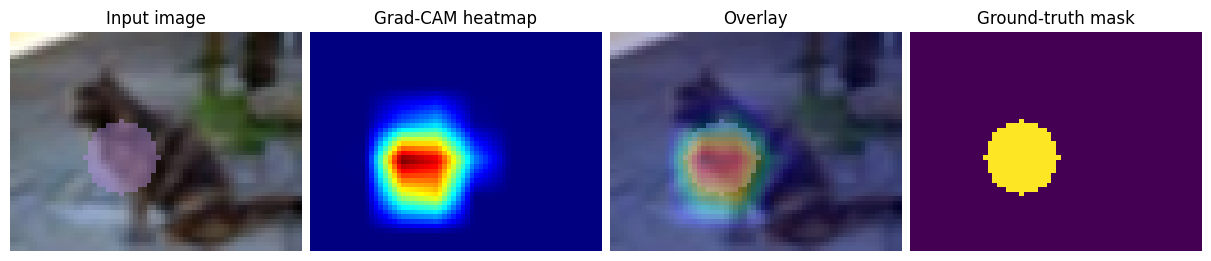

In [14]:
def example_gradcam():
    grad_cam = GradCAM(model=model, target_layers=target_layers)

    for test_idx in [3, 10, 42]:
        img, label, mask = test_dataset[test_idx]

        cam = grad_cam(img.unsqueeze(0).to(device), targets=[label])
        heatmap_img = heatmap_to_rgb_image(cam.squeeze(0), 0, 1)

        show_image_row(
            {
                "Input image": inverse_transform(img),
                "Grad-CAM heatmap": heatmap_img,
                "Overlay": PIL.Image.blend(inverse_transform(img), heatmap_img, alpha=0.3),
                "Ground-truth mask": mask,
            }
        )


example_gradcam()

Above are three examples visualizing how our Grad-CAM identified the appropriate regions for specific shapes:


1.   **Rhombus**: The heatmap looks good and covers the whole shape, but it highlights area slightly beyond object's boundaries.
1.   **Circle**: This visualization looks excellent, Grad-Cam marks the shape accurately.
2.   **Square**: The model focused on one edge of the quare rather than the entire shape, however, the localization is still fairly correct as it points to a distinctive feature of the object.



# 2. Segment Anything Model
---
In this part, we use the SAM model to perform automated image segmentation. The initial preimplmented *BasicSamPipeline* delivered unsuccessful results due to its naive assumption that target object is always located in the center of the image.

To improve it, four new SAM pipelines were implemented using the Grad-CAM approach. These pipelines identify points of the objects and the background, enhancing the efectiveness of segmentation.


## Basic usage [do not modify]
The checkpoint takes 360 MB.

In [15]:
%pip install segment-anything
!wget -nc -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [16]:
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide

sam_checkpoint_path = Path("./sam_vit_b_01ec64.pth")
assert sam_checkpoint_path.exists(), "SAM checkpoint not found."

# We'll use a single global SAM model to avoid reloading it to memory multiple times.
sam_model = sam_model_registry["vit_b"](checkpoint=sam_checkpoint_path)
sam_model.to(device)
sam_predictor = SamPredictor(sam_model)

In [17]:
class BasicSamPipeline:
    def __call__(self, images: Tensor) -> Tensor:
        """
        Input: normalized images, shape (B, C=3, H, W).
        Output: masks tensor of shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        # The basic pipeline always uses a single center point for each image.
        point_coords = np.array([[(W // 2, H // 2)] for _ in range(B)])

        # The basic pipeline always uses a single foreground point, no background points.
        point_labels = np.array([[1] for _ in range(B)], dtype=np.int64)

        return self.segment(images, point_coords, point_labels)

    def segment(
        self, images: Tensor, point_coords: np.ndarray, point_labels: np.ndarray
    ) -> Tensor:
        """
        Args:
        - images: normalized images, shape (B, C=3, H, W).
        - point_coords: point coordinates within each image, shape (B, num_points, 2), format (x,y).
            Note the format is not (h,w)=(y,x), but (x,y)!
        - point_labels: point labels, shape (B, num_points), dtype int64.
            Label 1 is foreground (should be in mask), 0 is background (shouldn't be in mask).

        Returns: segmentation masks, shape (B, H, W), dtype=bool.
        """
        B, C, H, W = images.shape
        assert C == 3, f"Expected images.shape=(B, C=3, H, W), got: {images.shape}"
        num_points = point_coords.shape[1]
        assert point_coords.shape == (B, num_points, 2), f"Expected point_coords.shape=({B=}, num_points, 2), got: {point_coords.shape}"
        assert point_labels.shape == (B, num_points), f"Expected point_labels.shape=({B=}, num_points), got: {point_labels.shape}"

        results = list[Tensor]()
        for image, pt_coords, pt_labels in zip(images, point_coords, point_labels, strict=True):
            sam_predictor.set_image(np.array(inverse_transform(image)))
            masks, scores, _logits = sam_predictor.predict(
                point_coords=pt_coords, point_labels=pt_labels, multimask_output=True
            )
            best_mask = masks[np.argmax(scores)]
            results.append(torch.tensor(best_mask, dtype=torch.bool))
        return torch.stack(results)

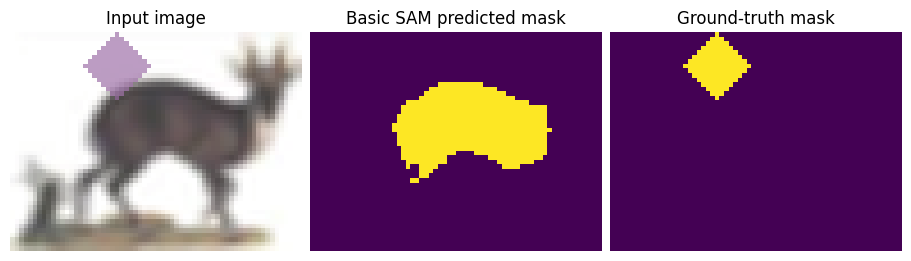

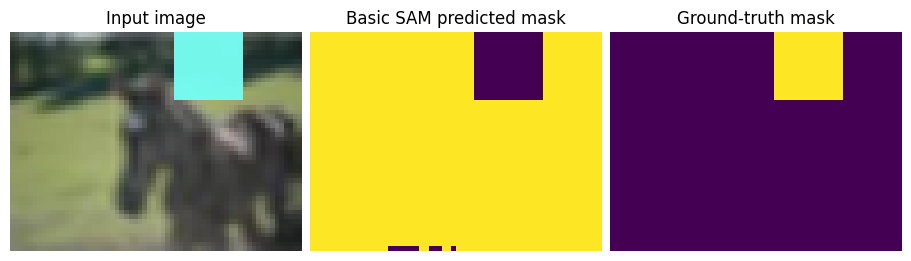

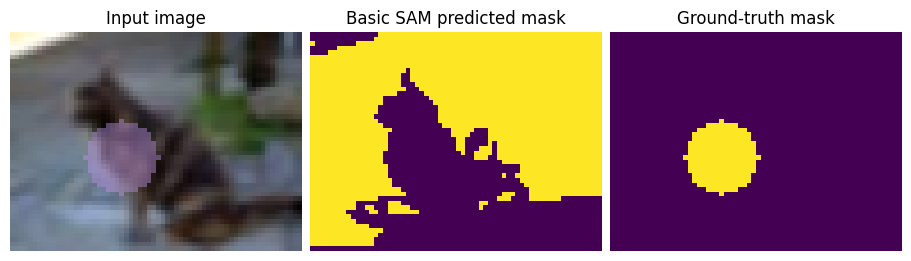

In [18]:
def example_sam():
    indices = [3, 10, 42]
    images, labels, gt_masks = next(iter(test_loader))
    images, labels, gt_masks = images[indices], labels[indices], gt_masks[indices]

    basic_pipeline = BasicSamPipeline()

    results = basic_pipeline(images).cpu()

    for image, result, gt_mask in zip(images, results, gt_masks, strict=True):
        show_image_row(
            {
                "Input image": inverse_transform(image),
                "Basic SAM predicted mask": result,
                "Ground-truth mask": gt_mask,
            }
        )


example_sam()

## Pipeline implementation and evaluation (add your code)

In [19]:
sam_eval_loader = DataLoader(test_dataset, batch_size=5, num_workers=0, pin_memory=use_accel)

Add any necessary cells regarding pipeline and evaluation.

In [20]:
# implementing new version of 'example_sam' function, which supports any SAM pipeline
def example_sam_v2(pipeline):
    indices = [3, 10, 42]
    images, labels, gt_masks = next(iter(test_loader))
    images, labels, gt_masks = images[indices], labels[indices], gt_masks[indices]
    images = images.to(device)

    results = pipeline(images).cpu()

    for image, result, gt_mask in zip(images, results, gt_masks, strict=True):
        show_image_row(
            {
                "Input image": inverse_transform(image),
                " SAM predicted mask": result,
                "Ground-truth mask": gt_mask,
            }
        )

***SamPipeline_FG*** implements a startegy where the pixel with highest intensity on the Grad-Cam heatmap is selected. This single point is treated as the most probable object location and passed to the SAM.

In [21]:
class SamPipeline_FG(BasicSamPipeline):
  def __init__(self, grad_cam: GradCAM):
    super().__init__()
    self.grad_cam = grad_cam

  def __call__(self, images: Tensor) -> Tensor:
      """
      Input: normalized images, shape (B, C=3, H, W).
      Output: masks tensor of shape (B, H, W), dtype=bool.
      """
      B, C, H, W = images.shape
      points = []

      # computing grad-cam
      cam = self.grad_cam(images.to(images.device), targets=None)

      # loop iterating through batch
      for i in range(B):
        # getting i-th heatmap
        heatmap = cam[i]

        # obtaining point with highest value on heatmap
        center_object = heatmap.argmax()
        y_object, x_object = np.unravel_index(center_object, heatmap.shape)

        # appending result
        points.append([(x_object, y_object)])

      # pipeline always uses a single foreground point, no background points
      point_labels = np.array([[1] for _ in range(B)], dtype=np.int64)

      # coverting to numpy array
      point_coords = np.array(points)

      # saving points, it will be useful during evaluation
      self.saved_points = point_coords

      return self.segment(images, point_coords, point_labels)

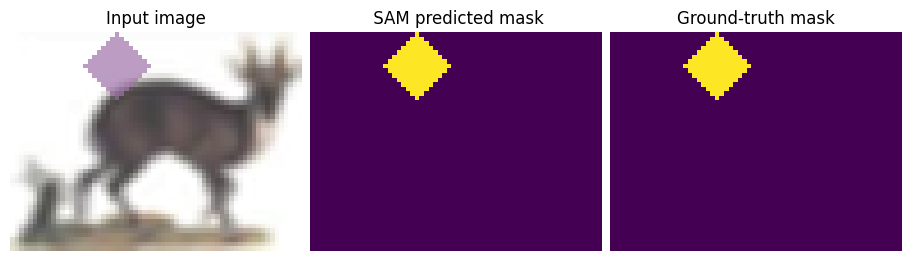

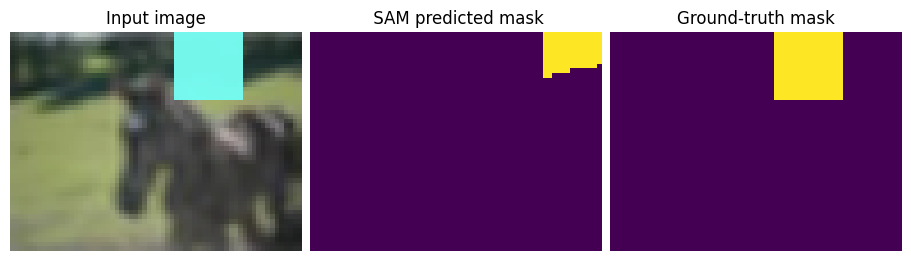

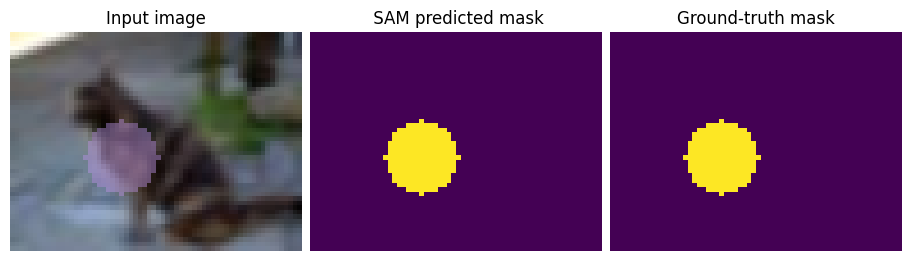

In [22]:
example_sam_v2(SamPipeline_FG(grad_cam = GradCAM(model=model, target_layers=target_layers)))

***SamPipeline_FGBG*** uses both the maximum and minimum value of the heatmap to identify the foreground and background points respectively. By marking the background, we aim to convey more information for the SAM model and, as a result, improve the performance.

In [23]:
class SamPipeline_FGBG(BasicSamPipeline):
  def __init__(self, grad_cam: GradCAM):
    super().__init__()
    self.grad_cam = grad_cam

  def __call__(self, images: Tensor) -> Tensor:
      """
      Input: normalized images, shape (B, C=3, H, W).
      Output: masks tensor of shape (B, H, W), dtype=bool.
      """
      B, C, H, W = images.shape

      # creating lists for foreground and background points
      points_fg = []
      points_bg = []

      # computing grad-cam
      cam = self.grad_cam(images.to(images.device), targets=None)

      # loop iterating through batch
      for i in range(B):
        # getting i-th heatmap
        heatmap = cam[i]

        # obtaining point with highest value on heatmap
        fg = heatmap.argmax()
        y_fg, x_fg = np.unravel_index(fg, heatmap.shape)
        points_fg.append([(x_fg, y_fg)])

        # obtaining point with lowest value on heatmap
        bg = heatmap.argmin()
        y_bg, x_bg = np.unravel_index(bg, heatmap.shape)
        points_bg.append([(x_bg, y_bg)])

      # combining results
      point_coords = np.concatenate((points_fg, points_bg), axis=1)

      #converting to numpy array
      point_coords = np.array(point_coords)

      # saving points, it will be useful during evaluation
      self.saved_points = point_coords

      # this pipeline uses one foreground point and one background point
      point_labels = np.array([[1, 0] for _ in range(B)], dtype=np.int64)

      return self.segment(images, point_coords, point_labels)

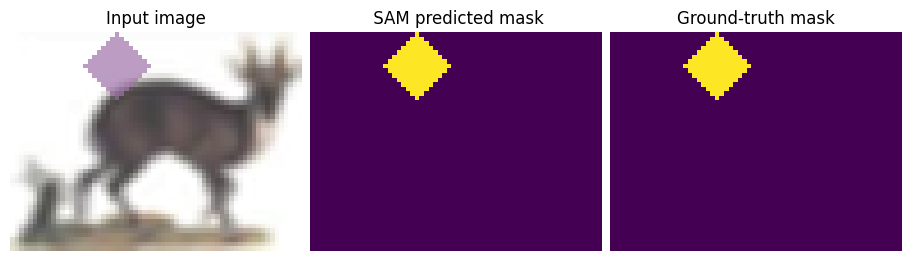

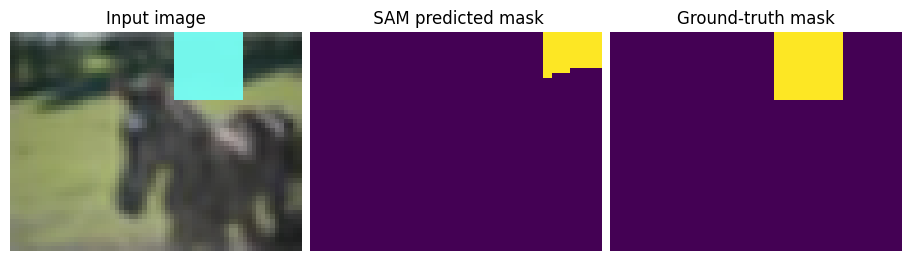

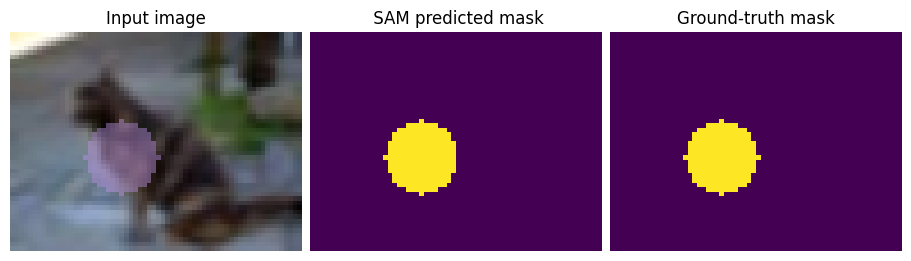

In [24]:
example_sam_v2(SamPipeline_FGBG(grad_cam = GradCAM(model=model, target_layers=target_layers)))

The visualizations whow that both pipelines perform well, offering a significant progress in comparison with the initial SAM pipeline. The results are truly similar for both *SamPipeline_FG* and *SamPipeline_FGBG*. The rhombus and circle are segmented accurately, however, the segmentation of square is much more precise.

In order to look for next upgrades, two new pipelines were implemented with more complex logic of extracting points.

***SamPipeline_FG2*** samples randomly 10 points from high-confidence regions of the Grad-CAM heatmap (values $\geq$ 0.9). By relying on multiple points, we aim to achieve more stable representation of object's location.

In [25]:
class SamPipeline_FG2(BasicSamPipeline):
  def __init__(self, grad_cam: GradCAM):
    super().__init__()
    self.grad_cam = grad_cam

  def __call__(self, images: Tensor) -> Tensor:
      """
      Input: normalized images, shape (B, C=3, H, W).
      Output: masks tensor of shape (B, H, W), dtype=bool.
      """
      B, C, H, W = images.shape
      points = []

      # number of points to draw
      n_points = 10

      # computing grad-cam
      cam = self.grad_cam(images.to(images.device), targets=None)

      # setting threshold for heatmap values
      threshold_up = 0.9

      # loop iterating through batch
      for i in range(B):
        # getting i-th heatmap
        heatmap = cam[i]

        ### Foreground points
        # getting points above 'threshold_up'
        candidates_fg = np.argwhere(heatmap >= threshold_up)

        # drawing 10 points at random from 'candidates_fg', which will be used to detect foreground object
        indicies_fg = np.random.choice(len(candidates_fg), n_points, replace=True)
        fg_points = candidates_fg[indicies_fg] # (y,x)
        # changing order from (y,x) to (x,y)
        fg_points = fg_points[:, [1,0]] # (x,y)

        # appending points
        points.append(fg_points)

      #converting to numpy array
      point_coords = np.array(points)

      # saving points, it will be useful during evaluation
      self.saved_points = point_coords

      # constructing labels suitable for our number of foreground
      labels_single_pattern = [1] * n_points
      point_labels = np.array([labels_single_pattern for _ in range(B)], dtype=np.int64)

      return self.segment(images, point_coords, point_labels)

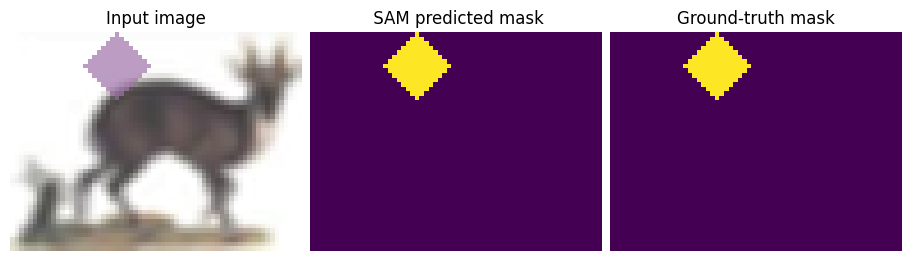

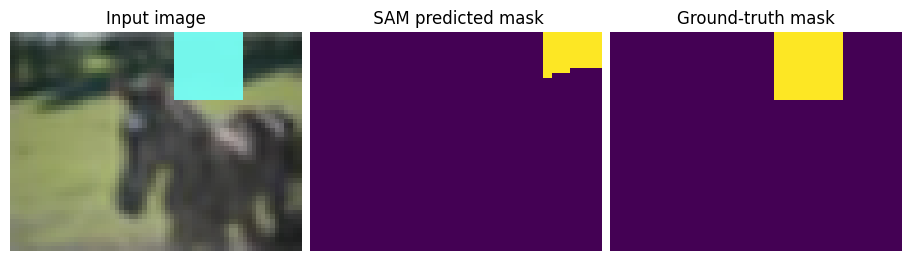

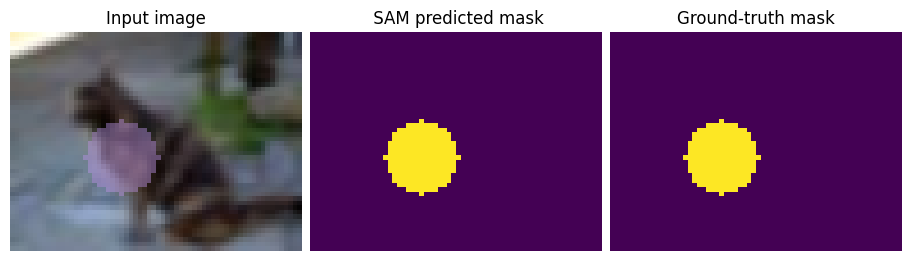

In [26]:
example_sam_v2(SamPipeline_FG2(grad_cam = GradCAM(model=model, target_layers=target_layers)))

***SamPipeline_FGBG2*** extends the idea of previous approach - it randomly select 10 foreground points (values $\geq$ 0.9) and 10 background points (values $\leq$ 0.2). This pipeline with an aim to make the system even more stable.

In [27]:
class SamPipeline_FGBG2(BasicSamPipeline):
  def __init__(self, grad_cam: GradCAM):
    super().__init__()
    self.grad_cam = grad_cam


  def __call__(self, images: Tensor) -> Tensor:
      """
      Input: normalized images, shape (B, C=3, H, W).
      Output: masks tensor of shape (B, H, W), dtype=bool.
      """
      B, C, H, W = images.shape
      points = []

      # number of points to draw
      n_points = 10

      # computing grad-cam
      cam = self.grad_cam(images.to(images.device), targets=None)

      # setting thresholds for heatmap values
      threshold_up = 0.9
      threshold_down = 0.2

      # loop iterating through batch
      for i in range(B):
        # getting i-th heatmap
        heatmap = cam[i]

        ### Foreground points
        # getting points above 'threshold_up'
        candidates_fg = np.argwhere(heatmap >= threshold_up)

        # drawing 10 points at random from 'candidates_fg', which will be used to detect foreground object
        indicies_fg = np.random.choice(len(candidates_fg), n_points, replace=True)
        fg_points = candidates_fg[indicies_fg] # (y,x)
        # changing order from (y,x) to (x,y)
        fg_points = fg_points[:, [1,0]] # (x,y)

        ### Background points
        # getting points below 'threshold_down'
        candidates_bg = np.argwhere(heatmap <= threshold_down)

        # drawing 10 points at random from 'candidates_bg', which will be used to detect background
        indicies_bg = np.random.choice(len(candidates_bg), n_points, replace=True)
        bg_points = candidates_bg[indicies_bg] #(y,x)
        # changing order from (y,x) to (x,y)
        bg_points = bg_points[:, [1,0]] #(x,y)

        # combining results
        points_combined = np.concatenate((fg_points, bg_points), axis=0)
        points.append(points_combined)

      # converting to numpy array
      point_coords = np.array(points)

      # saving points, it will be useful during evaluation
      self.saved_points = point_coords

      # constructing labels suitable for our number of foreground and background points
      labels_single_pattern = [1] * n_points + [0] * n_points
      point_labels = np.array([labels_single_pattern for _ in range(B)], dtype=np.int64)

      return self.segment(images, point_coords, point_labels)

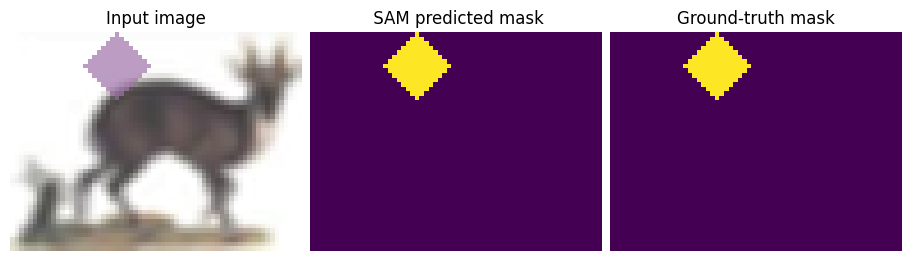

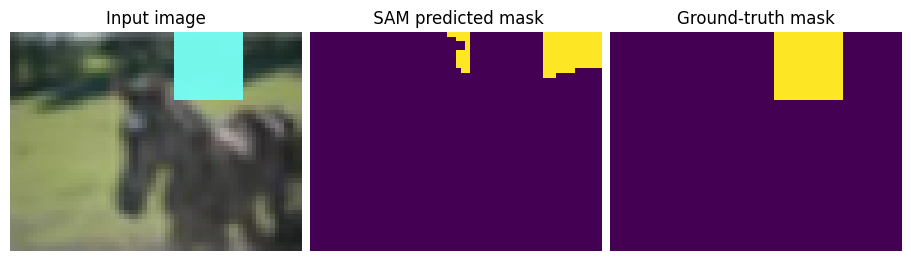

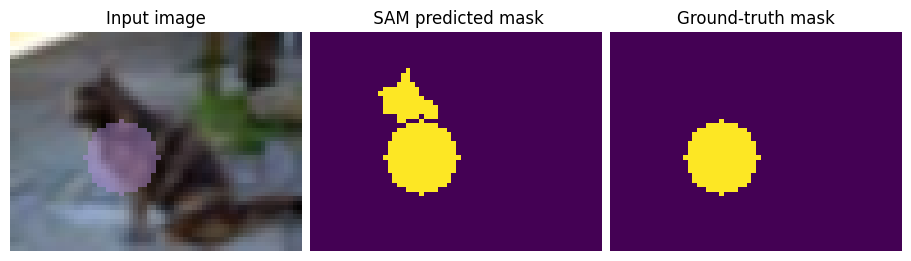

In [28]:
example_sam_v2(SamPipeline_FGBG2(grad_cam = GradCAM(model=model, target_layers=target_layers)))

Visualizations for *SamPipeline_FG2* seems remarkably similar to previous single-point methods. Conversly, the *SamPipeline_FGBG2* strategy did not perform as anticipated. Instead of enhancing performance and offering better results, it seems to sometimes mark larger, undesirable areas.

## Evaluation
----
In this section, the evaluation of four constructed pipelines will be done. Three metrics will be used - IoU, Hit Rate and Distance from center of mass of the ground truth mask.

In [29]:
### metrics and evalution section

from scipy.ndimage import center_of_mass

def calculate_metrics(prediction_mask, gt_mask, fg_points):
  """
  Function responsible for computing metrics for single image.
  Computes IoU, Hit Rate and Distance from center of mass.
  """

  # IoU metric
  intersection = (prediction_mask & gt_mask).sum()
  union = (prediction_mask | gt_mask).sum()
  iou = intersection / union

  # Hit Rate and Distance metrics
  # preparation before the loop
  hits = 0
  total_distance = 0
  n_points = len(fg_points)

  # calculating center of mass of ground truth
  center_y, center_x = center_of_mass(gt_mask)

  # loop iterating through all points
  for point in fg_points:
    x = point[0]
    y = point[1]

    # Hit Rate update
    if gt_mask[y, x] == 1:
      hits += 1

    # Distance update
    total_distance += np.sqrt((center_x - x)**2 + (center_y - y)**2)

  # final Hit Rate and Distance
  hit_rate = hits / n_points
  avg_distance = total_distance / n_points

  return iou, hit_rate, avg_distance

In [30]:
# Evaluation function

def evaluation_sam(pipeline, dataloader, name="Method"):
  print(f"Evaluation for method: {name}")

  iou_scores = []
  hitrate_scores = []
  distance_scores = []

  grad_cam = pipeline.grad_cam

  # evaluation loop
  for images, labels, gt_masks in tqdm(dataloader, desc=name):
    images = images.to(device)

    # getting prediction using SAM pipeline
    prediction_masks = pipeline(images)

    # obtaining points used by pipeline to generate prediction mask
    used_points = pipeline.saved_points

    # loop through batch
    for i in range(images.shape[0]):
      # getting parameters for certain image
      gt_mask = gt_masks[i]
      prediction_mask = prediction_masks[i]
      points = used_points[i]

      n_points = len(points)

      # logic for extracting foreground points from 'points' depending on pipeline
      if "BG" in name:
        n_fg = n_points // 2 # number of foreground points
        # taking only forefround points
        points = points[:n_fg]

      # calculations of metrics
      iou, hitrate, distance = calculate_metrics(prediction_mask=prediction_mask, gt_mask=gt_mask, fg_points=points)

      # updating lists with metrics
      iou_scores.append(iou)
      hitrate_scores.append(hitrate)
      distance_scores.append(distance)

    # calculating mean scores
    mean_iou = np.mean(iou_scores)
    mean_hitrate = np.mean(hitrate_scores)
    mean_distance = np.mean(distance_scores)

    # printing results
    print(f"Results for: {name}")
    print(f"Mean IoU: {mean_iou}")
    print(f"Mean Hit Rate: {mean_hitrate}")
    print(f"Mean Distance: {mean_distance}")

    return mean_iou, mean_hitrate, mean_distance

In [31]:
# Evaluation for 'SamPipeline_FG'
iou_fg, hr_fg, d_fg = evaluation_sam(SamPipeline_FG(grad_cam = GradCAM(model=model, target_layers=target_layers)), test_loader, name="FG")

Evaluation for method: FG


FG:   0%|          | 0/1 [03:53<?, ?it/s]

Results for: FG
Mean IoU: 0.7276493906974792
Mean Hit Rate: 0.686
Mean Distance: 5.982288682459799


In [32]:
# Evaluation for 'SamPipeline_FGBG'
iou_fgbg, hr_fgbg, d_fgbg = evaluation_sam(SamPipeline_FGBG(grad_cam = GradCAM(model=model, target_layers=target_layers)), test_loader, name="FGBG")

Evaluation for method: FGBG


FGBG:   0%|          | 0/1 [03:55<?, ?it/s]

Results for: FGBG
Mean IoU: 0.7210771441459656
Mean Hit Rate: 0.686
Mean Distance: 5.982288682459799


In [33]:
# Evaluation for 'SamPipeline_FG2'
iou_fg2, hr_fg2, d_fg2 = evaluation_sam(SamPipeline_FG2(grad_cam = GradCAM(model=model, target_layers=target_layers)), test_loader, name="FG2")

Evaluation for method: FG2


FG2:   0%|          | 0/1 [03:55<?, ?it/s]

Results for: FG2
Mean IoU: 0.756564199924469
Mean Hit Rate: 0.7032
Mean Distance: 5.868790178962301


In [34]:
# Evaluation for 'SamPipeline_FGBG2'
iou_fgbg2, hr_fgbg2, d_fgbg2 = evaluation_sam(SamPipeline_FGBG2(grad_cam = GradCAM(model=model, target_layers=target_layers)), test_loader, name="FGBG2")

Evaluation for method: FGBG2


FGBG2:   0%|          | 0/1 [03:55<?, ?it/s]

Results for: FGBG2
Mean IoU: 0.5223866105079651
Mean Hit Rate: 0.6994000000000001
Mean Distance: 5.891401082142742


**Evaluation results**



1.   ***SamPipeline_FG***: this basic approach performed satisfactorily, achievieng an average IoU of $72,8$% (which is higher than $65$% requirement for this project), an average Hit Rate of $68,6$% and average Distance of $5,98$.
2.   ***SamPipeline_FGBG***: performed similarly to the previous approach, however, it resulted in slightly lower IoU metric ($72,1$%).
3.   ***SamPipeline_FG2***: this strategy emerged as the best approach - increasing the number of foreground points improved all three metrics. IoU reached $75,7$%, the Hit Rate $70,3$% and the Distance $5,86$.
4.   ***SamPipeline_FGBG2***: this approach performed the worst, confirming the observations from previous that this pipeline does not behave as anticipated. The IoU dropped significantly to $52,2$%, while the Hit Rate and the Distance were at similar levels to previous methods.